[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


1. Loading 20 Newsgroups dataset...
2. Preprocessing documents (this may take a moment)...
   - Dictionary size: 5430 unique tokens
   - Corpus size: 9651 documents
3. Training LDA Model (this may take 2-5 minutes)...

--- Top Keywords per Topic ---
Topic 0: 0.011*"people" + 0.009*"think" + 0.008*"christian" + 0.007*"believe" + 0.007*"question" + 0.006*"jesus" + 0.006*"word" + 0.006*"know" + 0.006*"church" + 0.005*"thing"
Topic 1: 0.017*"know" + 0.017*"like" + 0.014*"time" + 0.013*"people" + 0.011*"said" + 0.010*"thing" + 0.010*"going" + 0.009*"think" + 0.008*"want" + 0.007*"year"
Topic 2: 0.012*"disease" + 0.011*"study" + 0.010*"medical" + 0.010*"health" + 0.009*"patient" + 0.009*"research" + 0.008*"university" + 0.008*"information" + 0.007*"number" + 0.007*"drug"
Topic 3: 0.023*"armenian" + 0.011*"muslim" + 0.011*"israel" + 0.009*"people" + 0.009*"jew" + 0.009*"turkish" + 0.008*"government" + 0.008*"israeli" + 0.007*"state" + 0.007*"arab"
Topic 4: 0.037*"space" + 0.015*"nasa" + 0.011

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   - Coherence Score: 0.6233

5. Generating t-SNE Visualization...


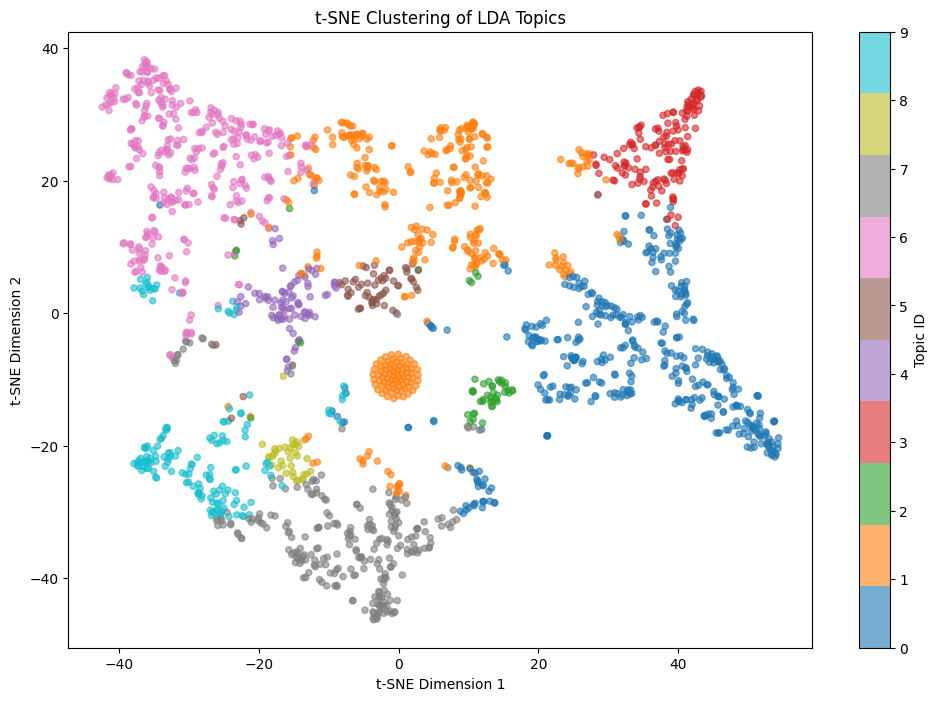


6. Testing Prediction...
Input: The Apple M5 chip is a new-generation processor for Mac comp...
Predicted Topic: 9 (Confidence: 0.43)
Topic Keywords: ['problem', 'window', 'driver', 'card', 'like']


In [10]:
# --- 1. IMPORTS ---
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE

# Gensim & NLP libraries
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk

# Download NLTK data (run once)
nltk.download('wordnet')
nltk.download('omw-1.4')


# --- 2. LOAD & PREPROCESS DATA ---
print("1. Loading 20 Newsgroups dataset...")
selected_categories = [
    "comp.graphics", "comp.os.ms-windows.misc", 'alt.atheism',
    "rec.autos", "rec.motorcycles", "rec.sport.baseball",
    'soc.religion.christian', 'talk.politics.mideast',
    "sci.med", "sci.space"
]

newsgroups = fetch_20newsgroups(
    subset='all',
    categories=selected_categories,
    remove=('headers', 'footers', 'quotes')
)
data_text = newsgroups.data

# Preprocessing Setup
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize & remove accents
    tokens = simple_preprocess(text, deacc=True)
    # Remove Stopwords, short words, and Lemmatize
    clean_tokens = [
        lemmatizer.lemmatize(token) 
        for token in tokens 
        if token not in STOPWORDS and len(token) > 3
    ]
    return clean_tokens

print("2. Preprocessing documents (this may take a moment)...")
processed_docs = [preprocess_text(doc) for doc in data_text]


# --- 3. CREATE DICTIONARY & CORPUS ---
# Create Dictionary
id2word = corpora.Dictionary(processed_docs)

# Filter extremes: Remove words in <15 docs or >50% of docs
id2word.filter_extremes(no_below=15, no_above=0.5)

# Create Corpus (Term Document Frequency)
corpus = [id2word.doc2bow(text) for text in processed_docs]

print(f"   - Dictionary size: {len(id2word)} unique tokens")
print(f"   - Corpus size: {len(corpus)} documents")


# --- 4. TRAIN LDA MODEL ---
print("3. Training LDA Model (this may take 2-5 minutes)...")
num_topics = 10
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    random_state=42,
    update_every=1,
    chunksize=1000,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Show topics
print("\n--- Top Keywords per Topic ---")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")


# --- 5. MODEL EVALUATION (COHERENCE) ---
print("\n4. Calculating Coherence Score...")
coherence_model_lda = CoherenceModel(
    model=lda_model, 
    texts=processed_docs, 
    dictionary=id2word, 
    coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print(f"   - Coherence Score: {coherence_lda:.4f}")


# --- 6. VISUALIZATION (t-SNE) ---
print("\n5. Generating t-SNE Visualization...")

# Get dominant topic distribution for a subset of documents
subset_size = 2000  # Use subset for speed
doc_topic_dist = []

for bow in corpus[:subset_size]:
    dist = lda_model.get_document_topics(bow, minimum_probability=0)
    probs = [prob for _, prob in dist]
    doc_topic_dist.append(probs)

doc_topic_matrix = np.array(doc_topic_dist)
dominant_topic_ids = np.argmax(doc_topic_matrix, axis=1)

# Run t-SNE
tsne_model = TSNE(n_components=2, verbose=0, random_state=42, init='pca', learning_rate='auto')
tsne_results = tsne_model.fit_transform(doc_topic_matrix)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    tsne_results[:, 0], 
    tsne_results[:, 1], 
    c=dominant_topic_ids, 
    cmap='tab10', 
    alpha=0.6, 
    s=20
)
plt.colorbar(scatter, label='Topic ID')
plt.title('t-SNE Clustering of LDA Topics')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


# --- 7. PREDICTION ON NEW TEXT ---
def predict_topic(text):
    tokens = preprocess_text(text)
    bow_vector = id2word.doc2bow(tokens)
    topic_probs = lda_model.get_document_topics(bow_vector)
    topic_probs = sorted(topic_probs, key=lambda x: x[1], reverse=True)
    
    if not topic_probs:
        return "No confident topic found."
    
    top_id, top_prob = topic_probs[0]
    terms = lda_model.show_topic(top_id, topn=5)
    keywords = [word for word, prop in terms]
    
    return top_id, top_prob, keywords

# Test Data
test_text = """
The Apple M5 chip is a new-generation processor for Mac computers, featuring a 
10-core CPU with faster multithreaded performance, a 16-core Neural Engine for AI tasks, 
and improved graphics.
"""

print("\n6. Testing Prediction...")
tid, tprob, tkeys = predict_topic(test_text)
print(f"Input: {test_text.strip()[:60]}...")
print(f"Predicted Topic: {tid} (Confidence: {tprob:.2f})")
print(f"Topic Keywords: {tkeys}")